# The Emissary of Lightning

In [31]:


import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.cluster import KMeansClusterer



In [14]:
'''
    This is a function for performing preprocessing step of the book.
    It takes as input the filename and outputs the story (punctuations removed), raw tokens, and lemmatized tokens
'''

def preprocess(pathToFile):
    import contractions
    import string
    from nltk.corpus import wordnet
    from nltk.corpus import stopwords
    from nltk.tag import pos_tag
    from nltk.stem import WordNetLemmatizer

    # load the book and convert to lowercase
    book = open(pathToFile, encoding="utf8").read().lower()

    # expand contractions
    expanded_words = [contractions.fix(word) for word in book.split()]
    book = ' '.join(expanded_words)

    # remove punctuations: using translate
    book = book.translate(str.maketrans('', '', string.punctuation))

    # tokenize
    tokens_raw = book.split()

    # limit to tokens with more than 2 characters
    tokens_raw = [token for token in tokens_raw if len(token) > 2]

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    more_stopwords = {'may','fellow', 'shall','let','must', 'upon'}
    stop_words.update(more_stopwords)

    tokens_filtered = [token for token in tokens_raw if not token in stop_words]

    # add POS tags for ease in lemmatization
    tokens_tagged = pos_tag(tokens_filtered)

    # define a lemmatizing function that uses POS tags
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)


    # Lemmatize filtered_tokens using the defined function
    tokens_lemmatized = [WordNetLemmatizer().lemmatize(token, get_wordnet_pos(token)) for token in tokens_filtered]
    
    return book, tokens_raw, tokens_lemmatized



In [12]:
corpusDictionary = {'book':[], 'rawTokens': [], 'lemmatizedTokens': []}

In [15]:
book = "C:/Users/echemochek/OneDrive/Desktop/vscodee/The Emissary of Lightning.txt"
corpusDictionary['book'], corpusDictionary['rawTokens'], corpusDictionary['lemmatizedTokens'] = preprocess(book)

In [ ]:
corpusDictionary['lemmatizedTokens']

In [26]:
corpusDictionary['top5words'] = []

tokens_cleaned = corpusDictionary['lemmatizedTokens']

freq = nltk.FreqDist(tokens_cleaned).most_common(5)
top5words = list(list(zip(*freq))[0])
corpusDictionary["top5words"].append(top5words)

In [27]:
corpusDictionary["top5words"]

[['alan', 'isaiah', 'one', 'lorm', 'soldier']]

<AxesSubplot:>

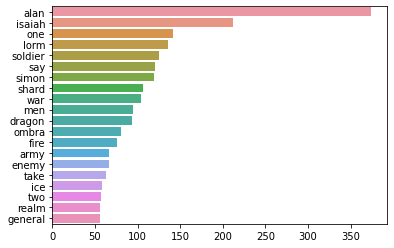

In [30]:
# most frequent non-stopwords

import collections
from collections import Counter
from nltk.corpus import stopwords

corpus = corpusDictionary['lemmatizedTokens']
stop = set(stopwords.words('english'))

counter = Counter(corpus)
most = counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)



In [32]:
# most frequent n-grams

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [36]:
# bigrams
top_bi_grams = get_top_ngram(corpusDictionary['lemmatizedTokens'], n=2)
x,y = map(list,zip(*top_bi_grams))
sns.barplot(x=y, y=x)

ValueError: empty vocabulary; perhaps the documents only contain stop words

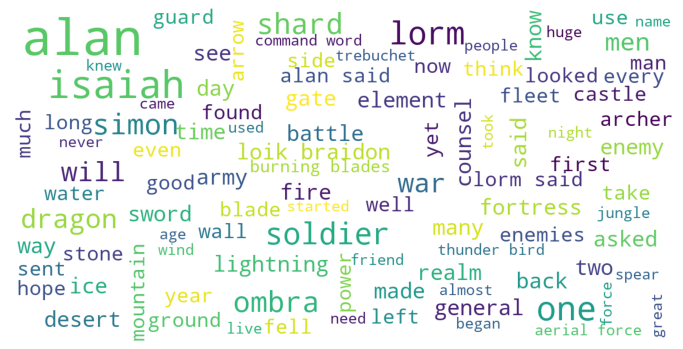

In [37]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=42)
   
    wordcloud = wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpusDictionary['book'])

In [39]:
# NER

nlp = spacy.load("en_core_web_sm")

def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = ner(corpusDictionary['book'])
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

<AxesSubplot:>

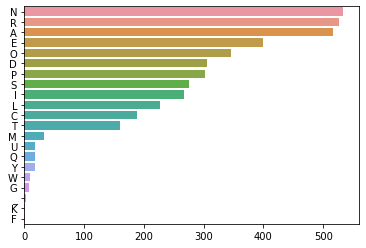

In [40]:
# entity frequencies visualization
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

In [42]:
# we can then visualize token per entity

def ner(text,ent="ORG"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

org = ner(corpusDictionary['book'])
org = [i for x in org for i in x]
counter = Counter(org)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y, x)

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given